# GeoFlood preprocessing 10m DEM data

In [1]:
"""
Return buffered digital elevation map (DEM)
 based on NFIE-defined catchments corresponding with the HUC12
 encompassing the area of interest

__author__ = "Daniel Hardesty Lewis"
__copyright__ = "Copyright 2020, Daniel Hardesty Lewis"
__credits__ = ["Daniel Hardesty Lewis"]
__license__ = "GPLv3"
__version__ = "1.0.0"
__maintainer__ = "Daniel Hardesty Lewis"
__email__ = "dhl@tacc.utexas.edu"
__status__ = "Production"
"""

'\nReturn buffered digital elevation map (DEM)\n based on NFIE-defined catchments corresponding with the HUC12\n encompassing the area of interest\n\n__author__ = "Daniel Hardesty Lewis"\n__copyright__ = "Copyright 2020, Daniel Hardesty Lewis"\n__credits__ = ["Daniel Hardesty Lewis"]\n__license__ = "GPLv3"\n__version__ = "1.0.0"\n__maintainer__ = "Daniel Hardesty Lewis"\n__email__ = "dhl@tacc.utexas.edu"\n__status__ = "Production"\n'

## Import needed modules

In [2]:
import fiona
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.io import MemoryFile
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio.mask
import os
from pathlib import Path

In [3]:
import contextily as ctx
import matplotlib.pyplot as plt
import rasterio.plot
import numpy.ma as ma

Correctly set GDAL_DATA environment variable
 (This is because Geopandas sometimes does not refer to the correct underlying libraries.)

In [4]:
oldgdal_data = os.environ['GDAL_DATA']
os.environ['GDAL_DATA'] = os.path.join(fiona.__path__[0],'gdal_data')

## Define input and output file locations

Define an empty object to consolidate all the arguments

In [5]:
args = type('', (), {})()

### Define the required input files

NHD MR GIS files with layers labelled Flowline and Catchment

In [6]:
args.nhd = "ATX/NFIEGeo_TX-ATX.gdb"

WBD HUC12 vector data

In [7]:
args.huc12 = "ATX/WBD_National_GDB-HU12-ATX.shp/WBD_National_GDB-HU12-ATX.shp"

Input vector GIS file with single polygon of the study area

In [8]:
args.shapefile = "ATX/ATX-Downtown.shp/ATX-Downtown.shp"

Input DEM file

In [9]:
args.raster = "ATX/USGS-ATX.tif"

### Check that the required input files have been defined correctly

In [10]:
if not args.shapefile:
    raise(ValueError('args.shapefile Input shapefile cutline not specified'))
if not isinstance(args.shapefile, str):
    raise(TypeError('args.shapefile Input shapefile cutline not a string'))
if not args.huc12 or not isinstance(args.huc12, str):
    raise(ValueError('args.huc12 Input HUC12 shapefile not specified'))
if not isinstance(args.shapefile, str):
    raise(TypeError('args.huc12 Input HUC12 shapefile not a string'))
if not args.nhd or not isinstance(args.nhd, str):
    raise(ValueError('args.nhd Input NHD geodatabase not specified'))
if not isinstance(args.shapefile, str):
    raise(TypeError('args.nhd Input NHD geodatabase not a string'))
if not args.raster or not isinstance(args.raster, str):
    raise(ValueError('args.raster Input raster not specified'))
if not isinstance(args.shapefile, str):
    raise(TypeError('args.raster Input raster not a string'))

### Define optional arguments

Optional distance to buffer the output raster

In [11]:
args.buffer = 500.

Optional directory for the output DEMs
 (The outputs will be organized by HUC)
 (If not defined, the output will be produced in the currect directory)
 
Note: ensure that this directory is writable.

In [12]:
## TODO: IO on DataX might require specific output location
args.directory = "ATX/Output"

### Check that the optional input arguments have been defined correctly

In [13]:
if args.buffer and not isinstance(args.buffer, float):
    raise(TypeError('args.buffer Buffer is not a floating point number'))
if args.directory and not isinstance(args.directory, str):
    raise(TypeError('args.directory Output directory is not a string'))

## Identify catchments and flowlines to HUCs

Read in a vector image which we will use to select HUC12 watersheds that enclose it, by intersection

In [14]:
shape = gpd.read_file(args.shapefile)

Visualize the HUC12 source data we will select HUC12s from.

In the center of the visualization, we can see the vector image 'args.shapefile' (outlined in red) is completely enclosed by a single HUC.

In [15]:
def visualize(gdfs,edgecolors=False,units=7.):

    f, ax = plt.subplots(figsize=(
        units,
        gdfs[0].shape[1]/gdfs[0].shape[0]*units
    ))
    if edgecolors==False:
        edgecolors = ['k']*len(gdfs)
    for i, gdf in enumerate(gdfs):
        gdf.to_crs(epsg=3857).plot(
            ax=ax,
            figsize=(
                units,
                gdfs[0].shape[1]/gdfs[0].shape[0]*units
            ),
            alpha=.5,
            edgecolor=edgecolors[i]
        )
    ctx.add_basemap(ax)
    plt.show()

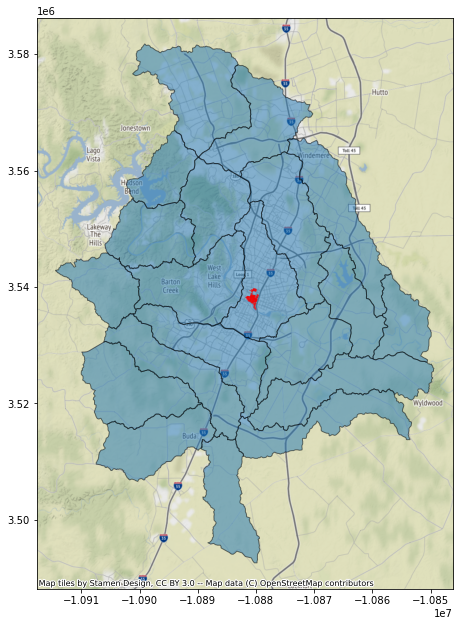

In [16]:
hu12 = gpd.read_file(args.huc12)

gdfs = [hu12,shape]
visualize(gdfs,edgecolors=['k','r'],units=10.)

This time, find the HUC12s that intersect with the input polygon, using the 'mask' option

In [17]:
hu12 = gpd.read_file(args.huc12, mask=shape)
hu12 = hu12[['HUC12','geometry']]

if len(hu12)!=1:
    raise(UserWarning('We will not process more than one HUC in this tutorial'))
hu = hu12['HUC12'][0]
hu12 = hu12.iloc[[0]]

We can now see that the enclosing HUC12 has been selected correctly.

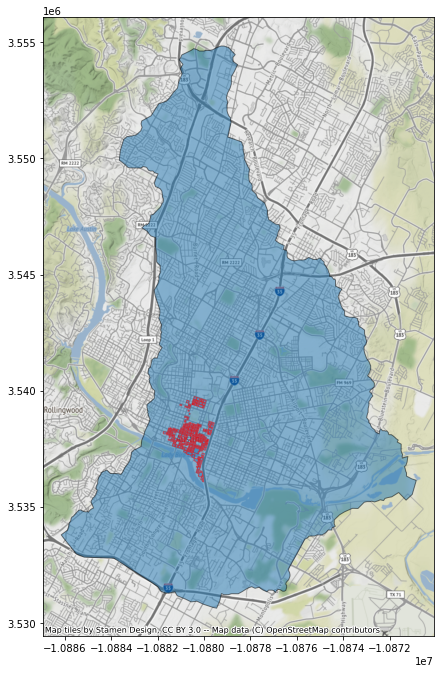

In [18]:
gdfs = [hu12,shape]
visualize(gdfs,edgecolors=['k','r'])

Here is the source catchment and flowline data we will be drawing from.

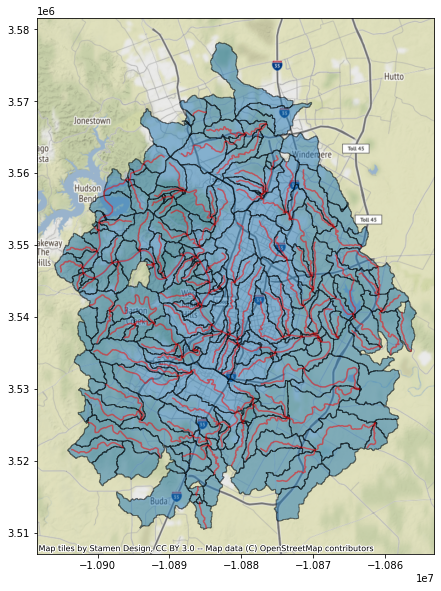

In [19]:
catchs = gpd.read_file(args.nhd, layer='Catchment')
flows = gpd.read_file(args.nhd, layer='Flowline')

gdfs = [catchs,flows]
visualize(gdfs,edgecolors=['k','r'],units=350.)

Find the flowlines whose representative points are within these HUC12s

In [20]:
flows = gpd.read_file(args.nhd, layer='Flowline', mask=hu12)
flows.drop(
    columns=[
        'Shape_Length',
        'Shape_Area',
        'AreaSqKM',
        'index_left',
        'index_right'
    ],
    inplace=True,
    errors='ignore'
)
flows.reset_index(inplace=True)
flows.set_index('COMID', inplace=True)
flows.sort_index(inplace=True)

flows_rep = flows.copy()
flows_rep['geometry'] = flows.representative_point()
flows_rep = gpd.sjoin(
    flows_rep,
    hu12.to_crs(flows_rep.crs),
    op='intersects',
    how='inner'
)
flows_rep.drop(
    columns=['index_left','index_right'],
    errors='ignore',
    inplace=True
)

Find the catchments corresponding with these flowlines

In [21]:
catchs = gpd.read_file(args.nhd, layer='Catchment')
catchs.reset_index(inplace=True)
catchs.set_index('FEATUREID', inplace=True)
catchs.sort_index(inplace=True)

catchs = catchs[catchs.index.isin(flows_rep.index)]

Find the flowlines corresponding with these cactchments

In [22]:
flows = flows[flows.index.isin(catchs.index)]

Determine which HUC12s each of the flowlines and catchments belong to
 (Note: because we have guaranteed that only 1 HUC will be treated,
 this step just copies the HUC12 ID to the flowline and catchment
 geodataframes. However, writing it this way is extensible to the
 multiple-HUC case.)

In [23]:
flows.loc[flows.index, 'HUC12'] = flows_rep.loc[flows.index, 'HUC12']
catchs.loc[catchs.index, 'HUC12'] = flows.loc[catchs.index, 'HUC12']

Absolutely ensure flowlines and catchments belong to each other

In [24]:
flows = flows[flows.is_valid]
catchs = catchs[catchs.is_valid]
catchs = catchs[catchs.index.isin(flows.index)]
flows = flows[flows.index.isin(catchs.index)]

Here we can see the representative points of each flowline which selected the corresponding catchment that belongs inside of this HUC12.

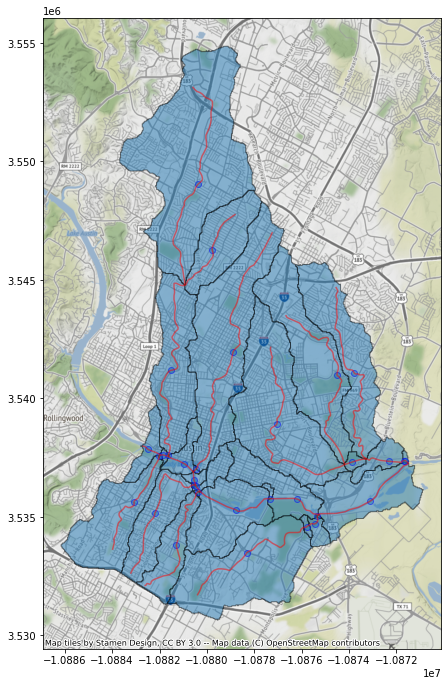

In [25]:
gdfs = [catchs, flows, flows_rep]
visualize(gdfs, edgecolors=['k','r','b'], units=40.)

## Buffer the HUC12 catchments

Create new HUC12 boundaries from the catchments pertaining to them

In [26]:
hu12catchs = catchs.dissolve(by='HUC12')

Find the appropriate metres-based coordinate reference system (CRS)

In [27]:
if hu12catchs.crs.datum.name=='World Geodetic System 1984':
    crs = 'epsg:32614'
elif (
    hu12catchs.crs.datum.name=='North American Datum 1983' or
    hu12catchs.crs.datum.name=='D_NORTH_AMERICAN_1983' or
    hu12catchs.crs.datum.name=='NAD83 (National Spatial Reference System 2011)'
):
    crs = 'epsg:6343'
else:
    raise(TypeError("Non-WGS/NAD datum not yet supported"))

Do the actual buffering in this CRS

In [28]:
if args.buffer:
    hu12catchs['geometry'] = hu12catchs.to_crs(crs).buffer(args.buffer)
else:
    hu12catchs['geometry'] = hu12catchs.to_crs(crs).buffer(500.)
hu12catchs.crs = crs
flows.to_crs(crs,inplace=True)
catchs.to_crs(crs,inplace=True)

The 500m buffer is clearly visible.

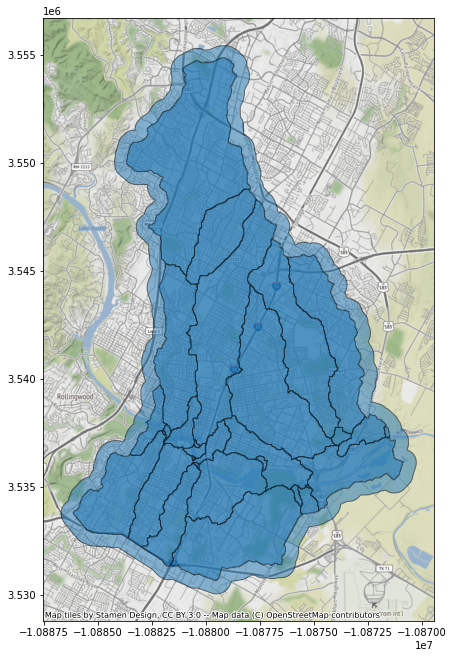

In [29]:
gdfs = [hu12catchs, catchs]
visualize(gdfs)

## Output the buffered DEM raster

Use this CRS as the output CRS for raster products

In [30]:
dst_crs = rasterio.crs.CRS.from_dict(init=crs)

Define the output directory location

In [31]:
## TODO: IO on DataX might require specific output location
prefix = os.path.splitext(os.path.basename(args.shapefile))[0]
subdirectory = os.path.join(args.directory, prefix+'-'+str(hu))
Path(subdirectory).mkdir(parents=True, exist_ok=True)

We will be checking the source raster's resolution to ensure it is at least 10m

In [32]:
def append_check(var,hu):

    if any(np.float16(i) > 10. for i in var.res):
        raise(TypeError('>10m raster input for HUC12: {hu}'.format(hu=repe(hu))))

Reproject the source raster, if projection differs from our desired projection

In [33]:
memfile = {}
memfile['dst'] = MemoryFile()
with rasterio.open(args.raster) as src:
    in_image = src.read()
    transform, width, height = calculate_default_transform(
        src.crs,
        dst_crs,
        src.width,
        src.height,
        *src.bounds
    )
    in_meta = src.meta.copy()
    out_meta = src.meta.copy()
    out_meta.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    ## Don't do an expensive reprojection if projection already correct
    with memfile['dst'].open(**out_meta) as dst:
        if src.meta==out_meta:
            dst.write(src.read())
        else:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=dst.transform,
                    dst_crs=dst.crs,
                    resampling=Resampling.nearest
                )
        append_check(dst, hu)
        hu_buff_geom = list(hu12catchs['geometry'])
        out_image, out_trans = rasterio.mask.mask(
            dst,
            hu_buff_geom,
            crop=True
        )

Here is the what the source DEM raster looks like.

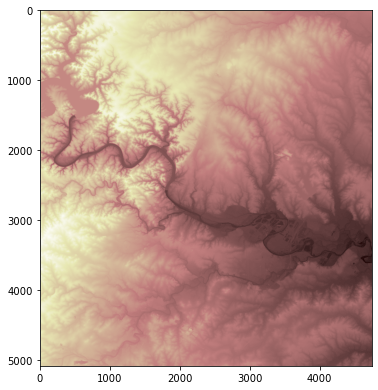

In [34]:
units = 7.
f, ax = plt.subplots(figsize=(
    units,
    in_image.squeeze().shape[1]/in_image.squeeze().shape[0]*units)
)
plt.imshow(
    ma.masked_array(in_image.squeeze(),
    mask=in_image.squeeze()==in_meta['nodata']),
    cmap='pink'
)
plt.show()

Crop and output the raster to the buffered catchments of the HUC

In [35]:
out_meta_orig = out_meta.copy()
out_meta.update({
    "height": out_image.shape[1],
    "width":out_image.shape[2],
    "transform": out_trans
})

path_elevation = os.path.join(subdirectory, 'Elevation.tif')
file_elevation = Path(path_elevation)
if file_elevation.is_file():
    file_elevation.unlink()

with rasterio.open(path_elevation, "w", **out_meta) as dst:
    dst.write(out_image)

Here's the final raster image of this HUC12 watershed.

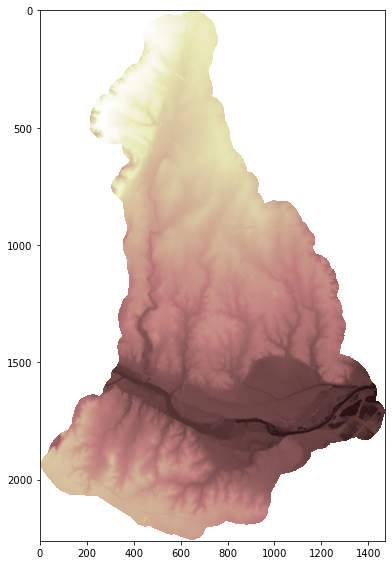

In [36]:
units = 15.
f, ax = plt.subplots(figsize=(
    units,
    out_image.squeeze().shape[1]/out_image.squeeze().shape[0]*units)
)
plt.imshow(
    ma.masked_array(out_image.squeeze(),
    mask=out_image.squeeze()==out_meta['nodata']),
    cmap='pink'
)
plt.show()

Reset the $GDAL_DATA environment variable we modified for this session

In [37]:
os.environ['GDAL_DATA'] = oldgdal_data

In [38]:
## TODO: Now expand on how to do the above for anywhere else in
##  Texas, referencing the locations of these inputs on Stampede2
## TODO: and how to do it outside of Texas by downloading the source DEM data from the National Map